fitbit_exploration

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# JSON API
import requests
import json

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from fbprophet import Prophet
import itertools as it
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math


%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from prepare import data_prepped
from prepare import missing_values_col

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv('test_fitbit.csv')
#df = pd.read_csv("saas.csv")

In [35]:
df.shape

(225, 10)

In [3]:
def missing_values_col(df):
    """
    Write or use a previously written function to return the
    total missing values and the percent missing values by column.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    return pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})

missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
date,0,0.00,0,0.00,0,0.00
calories_burned,0,0.00,0,0.00,0,0.00
steps,0,0.00,0,0.00,0,0.00
distance,0,0.00,0,0.00,0,0.00
floors,0,0.00,0,0.00,0,0.00
minutes_sedentary,0,0.00,0,0.00,0,0.00
minutes_lightly_active,0,0.00,0,0.00,0,0.00
minutes_fairly_active,0,0.00,0,0.00,0,0.00
minutes_very_active,0,0.00,0,0.00,0,0.00
activity_calories,0,0.00,0,0.00,0,0.00


In [4]:
def peekatdata(df):
    print("\n \n SHAPE:")
    print(df.shape)

    print("\n \n COLS:")
    print(df.columns)

    print("\n \n INFO:")
    print(df.info())

    print("\n \n Missing Values:")
    missing_vals = df.columns[df.isnull().any()]
    print(df.isnull().sum())

    print("\n \n DESCRIBE:")
    print(df.describe())

    print('\n \n HEAD:')
    print(df.head(5))

    print('\n \n TAIL:' )
    print(df.tail(5))

peekatdata(df)


 
 SHAPE:
(225, 11)

 
 COLS:
Index(['date', 'calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories', 'month_set'], dtype='object')

 
 INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 11 columns):
date                      225 non-null object
calories_burned           225 non-null int64
steps                     225 non-null int64
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null int64
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null int64
month_set                 225 non-null int64
dtypes: float64(1), int64(9), object(1)
memory usage: 19.4+ KB
None

 
 Missing Values:
date                      0
calories_burned           0
s

In [5]:
def obj_to_nums(df):
    df[['calories_burned', 'steps','minutes_sedentary', 'activity_calories']] = df[['calories_burned', 'steps','minutes_sedentary','activity_calories']].astype(int)
    return df

df = obj_to_nums(df)
df.tail()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,month_set
220,2018-12-02,3957,13257,6.23,195,725,265,13,70,2305,8
221,2018-12-03,3660,12915,6.12,6,782,219,40,51,1993,8
222,2018-12-04,3384,13763,6.49,13,608,199,11,67,1663,8
223,2018-12-05,3670,13865,6.52,12,739,200,12,69,1968,8
224,2018-12-06,3669,14774,6.96,9,647,198,4,78,1962,8


In [6]:
df.head(2)

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,month_set
0,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1
1,2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1


In [7]:
def time_convert(df):
    datetime_format = '%Y %m %d'
    df['date'] = pd.to_datetime(df.date,format=datetime_format)
    return df

df = time_convert(df)
df

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,month_set
0,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1
1,2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1
2,2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,1
3,2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1
4,2018-04-30,2825,1323,0.62,0,880,104,0,0,540,1
5,2018-05-01,3292,2581,1.22,0,919,167,13,2,1068,1
6,2018-05-02,2660,1372,0.65,0,927,90,0,0,419,1
7,2018-05-03,3121,2232,1.05,0,876,157,16,0,1006,1
8,2018-05-04,2522,904,0.43,1,1012,61,0,0,269,1
9,2018-05-05,2551,833,0.39,0,969,68,0,0,326,1


In [8]:
def new_index(df):
    df = df.set_index('date')
    return df

df = new_index(df)

In [9]:
print('\nColumn Names:')
print(df.columns)
print('\nTotal number of columns:')
print(len(df.columns))


Column Names:
Index(['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories', 'month_set'], dtype='object')

Total number of columns:
10


In [10]:
df.describe()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,month_set
count,225.00,225.00,225.00,225.00,225.00,225.00,225.00,225.00,225.00,225.00
mean,"3,401.91","8,536.19",4.05,12.59,809.52,188.24,14.92,33.87,"1,484.55",4.16
std,632.43,"5,255.75",2.51,25.84,243.23,75.17,15.36,37.20,747.80,2.12
min,799.00,0.00,0.00,0.00,28.00,0.00,0.00,0.00,0.00,1.00
25%,"3,069.00","4,714.00",2.22,2.00,654.00,158.00,3.00,2.00,"1,062.00",2.00
50%,"3,385.00","7,806.00",3.68,7.00,750.00,203.00,11.00,15.00,"1,481.00",4.00
75%,"3,765.00","12,380.00",5.90,13.00,877.00,236.00,21.00,63.00,"1,962.00",6.00
max,"5,199.00","25,512.00",12.00,195.00,"1,440.00",349.00,78.00,154.00,"3,596.00",8.00


In [11]:
#df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [12]:
df.shape

(225, 10)

In [13]:
df.tail()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,month_set
date,,,,,,,,,,
2018-12-02,3957,13257,6.23,195,725,265,13,70,2305,8
2018-12-03,3660,12915,6.12,6,782,219,40,51,1993,8
2018-12-04,3384,13763,6.49,13,608,199,11,67,1663,8
2018-12-05,3670,13865,6.52,12,739,200,12,69,1968,8
2018-12-06,3669,14774,6.96,9,647,198,4,78,1962,8


In [14]:
monthly_resampled_data = df.calories_burned.resample('M').mean()

In [15]:
monthly_resampled_data

date
2018-04-30               3,067.80
2018-05-31               3,116.03
2018-06-30               2,972.60
2018-07-31               3,317.29
2018-08-31               3,753.61
2018-09-30               3,258.83
2018-10-31               3,574.45
2018-11-30               3,813.07
2018-12-31               3,692.17
Freq: M, Name: calories_burned, dtype: float64

In [16]:
aggregation = 'sum'

In [30]:
train = df[:'2018-10-31']
#.calories_burned.resample('D').agg(aggregation)
test = df['2018-11-01':]
#.calories_burned.resample('D').agg(aggregation)

In [31]:
train.shape

(189, 10)

In [32]:
test.shape

(36, 10)

In [33]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training: %d' % (len(train.values)))
print('Testing: %d' % (len(test.values)))

Observations: 225
Training: 189
Testing: 36


In [21]:
pd.concat([train.head(3), train.tail(3)])

date
2018-04-29    12514
2018-05-06    19742
2018-05-13    19189
2018-10-21    24464
2018-10-28    25256
2018-11-04    11285
Name: calories_burned, dtype: int64

In [22]:
pd.concat([test.head(3), test.tail(3)])

date
2018-11-04    16326
2018-11-11    27901
2018-11-18    26702
2018-11-25    26323
2018-12-02    24910
2018-12-09    14383
Name: calories_burned, dtype: int64

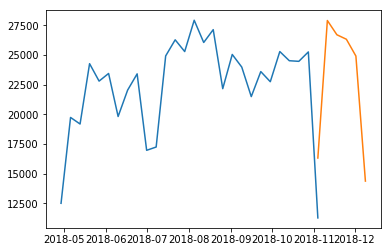

In [23]:
plt.plot(train)
plt.plot(test)
plt.show()

In [24]:
y_hat = pd.DataFrame(dict(actual=test))

y_hat['calorie_forecast'] = train.mean()
y_hat.tail()

,actual,calorie_forecast
date,,
2018-11-11,27901,"22,460.18"
2018-11-18,26702,"22,460.18"
2018-11-25,26323,"22,460.18"
2018-12-02,24910,"22,460.18"
2018-12-09,14383,"22,460.18"


In [25]:
y_hat.describe()

,actual,calorie_forecast
count,6.00,6.00
mean,"22,757.50","22,460.18"
std,"5,845.63",0.00
min,"14,383.00","22,460.18"
25%,"18,472.00","22,460.18"
50%,"25,616.50","22,460.18"
75%,"26,607.25","22,460.18"
max,"27,901.00","22,460.18"


In [26]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for y_hat in predictions:
        mse, rmse = evaluate(actual, y_hat, output=False)        
        label = f'{y_hat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(y_hat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()   

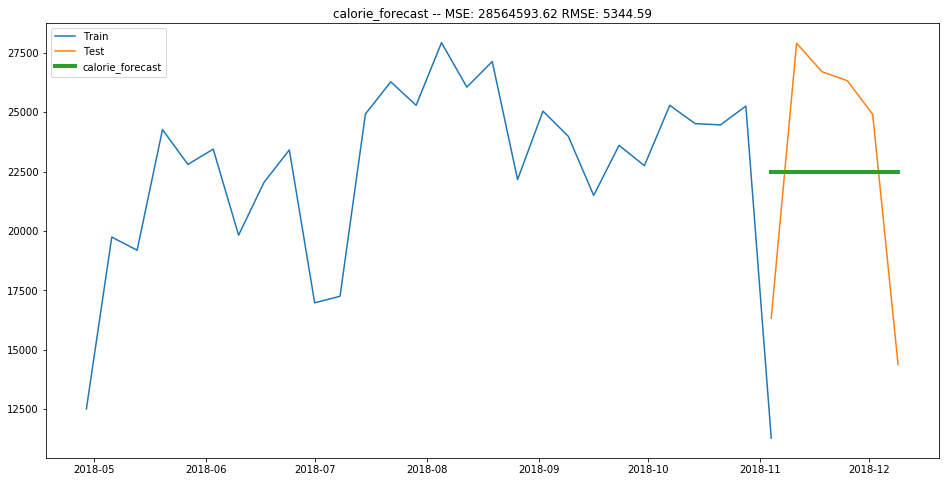

In [27]:
plot_and_eval(y_hat.calorie_forecast)

In [28]:
periods = 34
y_hat['calorie_forecast'] = train.rolling(34).mean().iloc[:-1]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

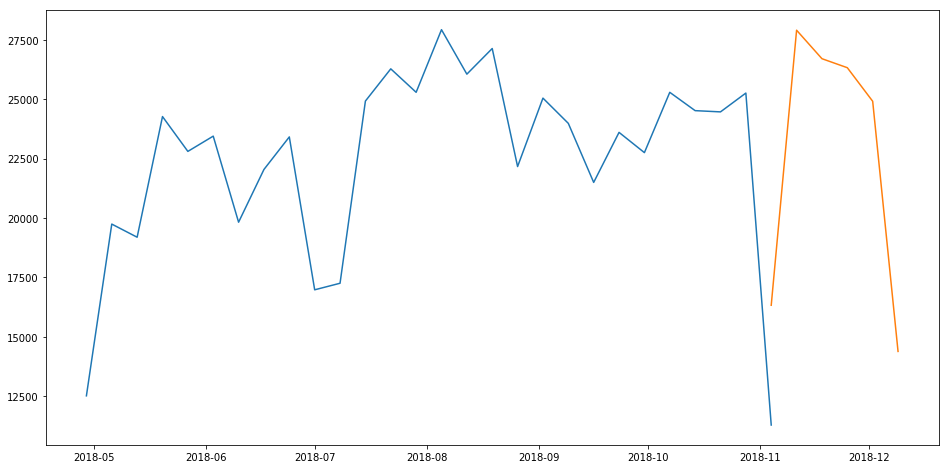

In [29]:
plot_and_eval(y_hat.calorie_forecast)

In [ ]:
# def drop_blank_charge(df):
#     df2 = df.copy()
#     df2 = df2[df2['total_charges'] != ' ']
#     df2['total_charges'] = df2.total_charges.astype(float)
#     return df2